### SIR Universal Differential Equation

We are using the famous SIR (Suseptible, Infected, Recovered) model used for modeling spread in epidemiology using UDE.
\begin{align*}\frac{d S}{dt} = -τ_{SI} * S * I ,\end{align*}
\begin{align*}\frac{d I}{dt} = +τ_{SI} * S * I -τ_{IR} * I ,\end{align*}
\begin{align*}\frac{d R}{dt} = +τ_{IR} * I ,\end{align*}

Where we use NN to get values of τ_{SI} and τ_{IR}

In [1]:
!pip install torchdiffeq

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp # Numerically solve to simulate real data
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint # Numericaly integrate UDe

%matplotlib inline

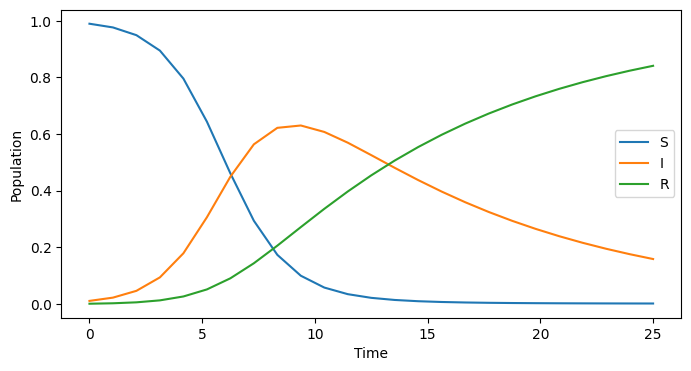

In [3]:
# Physical Parameters
N_days = 25 # Simulation dates
S0 = 1.0 # Total population

# Initial Conditions
u0 = [S0*0.99, S0*0.01, 0.0] # Initial Susceptible (99%), Initial Infected (1%), Intial Recovered (0%)
p0 = [0.85, 0.1] # Real 𝜏SI and 𝜏IR for simulation

t_span = [0.0, float(N_days)] # Time span
t = np.linspace(t_span[0], t_span[1], N_days) # Simulation dates

# Convert initial conditions to tensor
u0_tensor = torch.tensor(u0, dtype=torch.float32)
t_span_tensor = torch.linspace(0.0, float(N_days), N_days)
# Simulation of real ground truth
def SIR(t,u,p):
  S,I,R = u
  τSI, τIR = list(map(abs, p)) # Parameter should be non negative
  S_dot = -τSI * S * I
  I_dot = τSI * S * I - τIR * I
  R_dot = τIR * I
  return [S_dot, I_dot, R_dot]

sol = solve_ivp(SIR, t_span, u0, t_eval=t, args=(p0,), method='RK45')
S_true = sol.y[0, :]
I_true = sol.y[1, :]
R_true = sol.y[2, :]

# Plot the ground truth data
plt.figure(figsize=(8, 4))
plt.plot(t, S_true, label='S')
plt.plot(t, I_true, label='I')
plt.plot(t, R_true, label='R')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [4]:
# Define neural network to determine τSI and τIR
class TauNN(nn.Module):
  def __init__(self, input_size, hidden_size=10):
    super(TauNN, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, 1)
    )

  def forward(self, x):
    return self.net(x)

class NeuralSI(nn.Module):
    def __init__(self, hidden_size=10):
        super(NeuralSI, self).__init__()
        self.network = TauNN(input_size=2, hidden_size=hidden_size)

    def forward(self, S, I):
        x = torch.stack([S, I])
        return self.network(x)

class NeuralIR(nn.Module):
    def __init__(self, hidden_size=10):
        super(NeuralIR, self).__init__()
        self.network = TauNN(input_size=1, hidden_size=hidden_size)

    def forward(self, I):
        x = I.reshape(1, 1)
        return self.network(x)
# Create NN for τSI and τIR
model_τSI = NeuralSI()
model_τIR = NeuralIR()

In [5]:
# Define SIR model
class SIR_UDE_Model(nn.Module):
  def __init__(self, model_τSI, model_τIR):
    super(SIR_UDE_Model, self).__init__()
    self.model_τSI = model_τSI
    self.model_τIR = model_τIR

  def forward(self, t, u):
    S,I,R = u
    τSI_pred = self.model_τSI(S,I)
    τIR_pred = self.model_τIR(I)

    # Apply activation and clamp using NumPy
    τSI = torch.clamp(torch.log(1 + torch.exp(τSI_pred)), 1e-5, 1.0).squeeze()
    τIR = torch.clamp(torch.log(1 + torch.exp(τIR_pred)), 1e-5, 1.0).squeeze()

    # Apply UDE dynamics
    S_dot = -τSI * S * I
    I_dot = τSI * S * I - τIR * I
    R_dot = τIR * I

    return torch.stack([S_dot, I_dot, R_dot]) # return as a list of NumPy values

In [6]:
# Define the loss function
def loss_function(model_τSI, model_τIR):
  ude_model = SIR_UDE_Model(model_τSI, model_τIR)
  try:
    # Numerically integrate
    sol = odeint(ude_model, u0_tensor, t_span_tensor, method='rk4')

    # Check for numerical stability
    if torch.any(torch.isnan(sol)):
      return torch.tensor(float('inf'), requires_grad=True)

    # Calculate the MSE
    pred_I = sol[:,1]
    true_I = torch.tensor(I_true, dtype=torch.float32)
    mse = torch.sum((pred_I - true_I)**2) # Checking only for Infected cases, can also be done for combination for all S,I,R

    return mse

  except Exception as e:
    print(f"Error: {e}")
    return torch.tensor(float('inf'), requires_grad=True)

In [7]:
# Train the model
def closure():
  optimizer.zero_grad()
  loss = loss_function(model_τSI, model_τIR)
  print(f"Loss: {loss.item()}")
  loss.backward()
  return loss

parameters = list(model_τSI.parameters()) + list(model_τIR.parameters())
optimizer = optim.LBFGS(parameters, lr=0.1, max_iter=20, line_search_fn='strong_wolfe')

print("Training the SIR UDE model")
optimizer.step(closure)
loss = loss_function(model_τSI, model_τIR)
print(f"Final Loss: {loss.item()}")

Training the SIR UDE model
Loss: 3.5150558948516846
Loss: 3.495898723602295
Loss: 3.3007049560546875
Loss: 1.4296889305114746
Loss: 0.7424283027648926
Loss: 0.9069545269012451
Loss: 0.08037739992141724
Loss: 0.08686558157205582
Loss: 0.07976777106523514
Loss: 0.07911130785942078
Loss: 0.07327764481306076
Loss: 0.0517115592956543
Loss: 0.04623625427484512
Loss: 0.04268529638648033
Loss: 0.015573889017105103
Loss: 0.014750122092664242
Loss: 0.014252371154725552
Loss: 0.013352317735552788
Loss: 0.013326678425073624
Loss: 0.013207138516008854
Loss: 0.013196097686886787
Loss: 0.013149453327059746
Loss: 0.013081470504403114
Loss: 0.012619462795555592
Loss: 0.012510256841778755
Loss: 0.011646694503724575
Final Loss: 0.011646694503724575


In [8]:
# Inference
trained_model = SIR_UDE_Model(model_τSI, model_τIR)
with torch.no_grad():
  trained_sol = odeint(trained_model, u0_tensor, t_span_tensor, method='rk4').numpy()

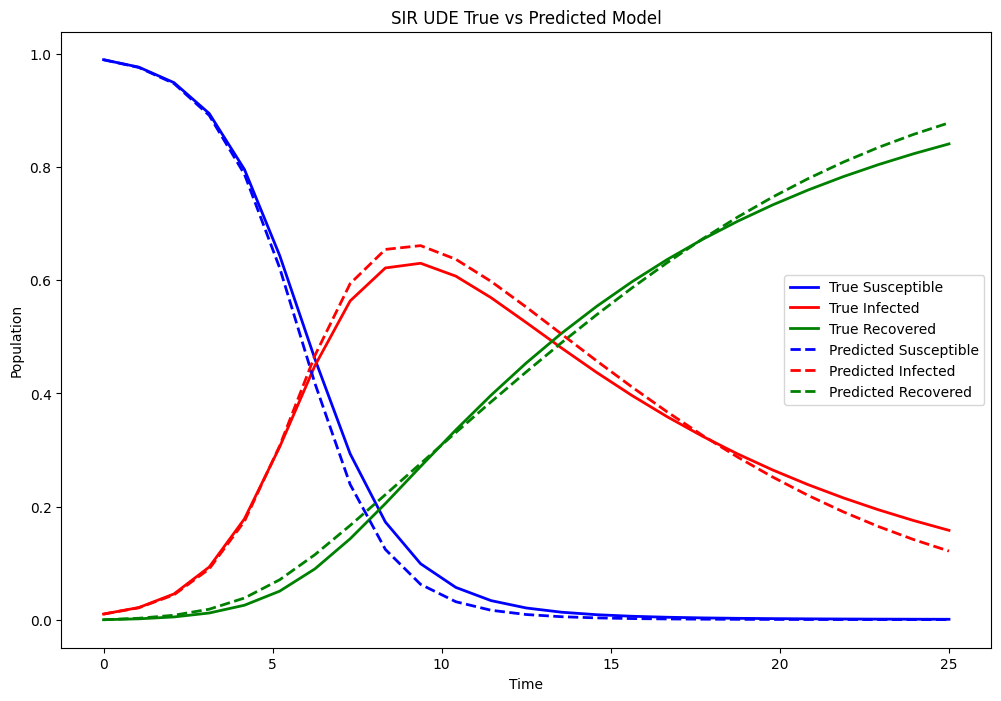

In [9]:
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(t, S_true, label="True Susceptible", color="blue", linewidth=2)
plt.plot(t, I_true, label="True Infected", color="red", linewidth=2)
plt.plot(t, R_true, label="True Recovered", color="green", linewidth=2)

plt.plot(t, trained_sol[:,0], label="Predicted Susceptible", linewidth=2, linestyle='--', color='blue')
plt.plot(t, trained_sol[:,1], label="Predicted Infected", linewidth=2, linestyle='--', color='red')
plt.plot(t, trained_sol[:,2], label="Predicted Recovered", linewidth=2, linestyle='--', color='green')

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SIR UDE True vs Predicted Model")
plt.legend()
plt.show()

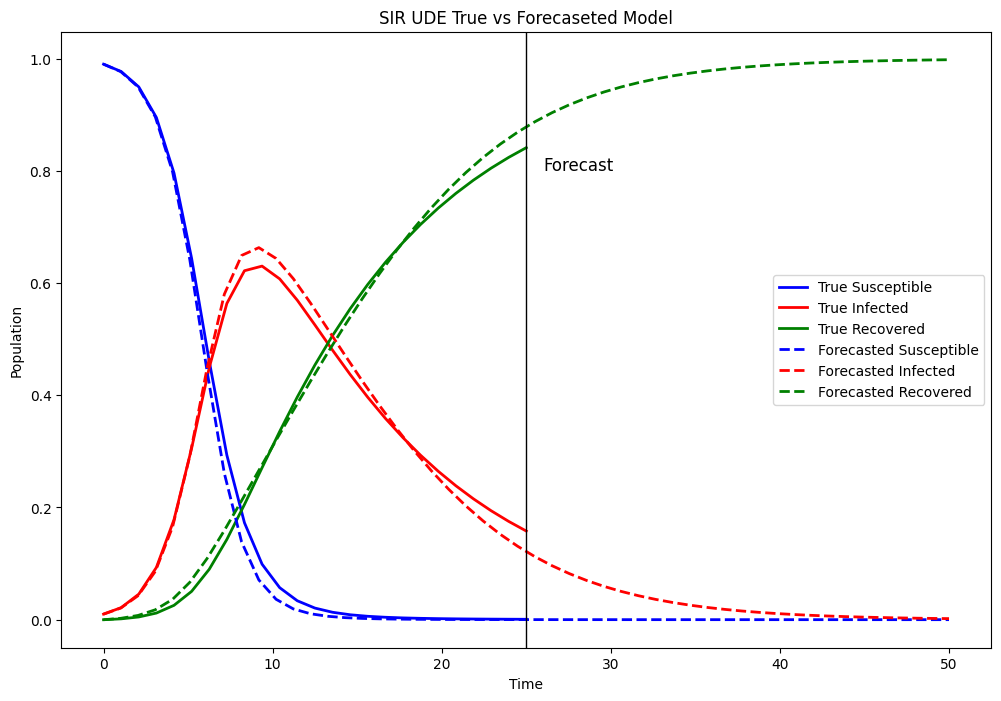

In [10]:
# Forecast
N_days2 = 50
t_span_tensor2 = torch.linspace(0.0, float(N_days2), N_days2)
with torch.no_grad():
  forecast_sol = odeint(trained_model, u0_tensor, t_span_tensor2, method='rk4').numpy()

plt.figure(figsize=(12, 8))
plt.plot(t, S_true, label="True Susceptible", color="blue", linewidth=2)
plt.plot(t, I_true, label="True Infected", color="red", linewidth=2)
plt.plot(t, R_true, label="True Recovered", color="green", linewidth=2)

plt.plot(t_span_tensor2.numpy(), forecast_sol[:,0], label="Forecasted Susceptible", linewidth=2, linestyle='--', color='blue')
plt.plot(t_span_tensor2.numpy(), forecast_sol[:,1], label="Forecasted Infected", linewidth=2, linestyle='--', color='red')
plt.plot(t_span_tensor2.numpy(), forecast_sol[:,2], label="Forecasted Recovered", linewidth=2, linestyle='--', color='green')

plt.axvline(x=N_days, color='black', linestyle='-', linewidth=1)
plt.text(N_days+1, 0.8, 'Forecast', fontsize=12)

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SIR UDE True vs Forecaseted Model")
plt.legend()
plt.show()